In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook

import glob, os

from astropy.table import Table
plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scripts import *

In [148]:
targets2 = Table.read('m_dwarf_dections_27_03_20_correct_fluxes.fits')

In [150]:
targets2['common_name']

GJ 412
LP 212-62
LP 169-22
GJ 3789
GJ 1151
2MASS J09481615+5114518
2MASS J10534129+5253040
G 240-45
GJ 3729
GJ 3861
GJ 9552


In [127]:
targets = Table.read('names_best_cands_4sig_stokesv_clean_leakage_gaia_propermotion_applied stars_added_2019_10_24.fits')
names = targets['common_name']
name = 'CR Dra'
name = names[2].strip()
name = '44 Boo'

In [128]:
tics, time, flux, errs, sects, data_all = load_lightcurve(name)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [129]:
search = lk.search_lightcurvefile(name)

In [130]:
search = search[np.where(search.target_name==search.target_name[0])]


In [131]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|██████████| 3/3 [00:00<00:00, 18.57it/s]


0.1339096785258095


In [132]:
avg_preds = run_cnn(tics,time,flux,errs)

Can only use stella.ConvNN.predict().


100%|██████████| 3/3 [00:10<00:00,  3.49s/it]


In [133]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)
flare_table.write('flares_%s.csv' % (name.replace(' ','_').lower()),format='ascii')

Finding & Fitting Flares: 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]


In [134]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

0.3811919819963578 1 / d


In [135]:
sectors

[14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26]

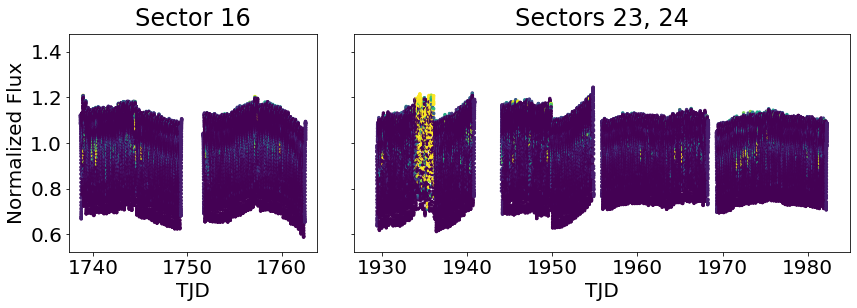

In [136]:
groups,sectors = group_sectors(data_all)
ngroups = len(groups)
width_ratios = [len(group) for group in groups] 
fig, axes = plt.subplots(ncols=ngroups, figsize=(ngroups*7,4),
                           sharey=True, gridspec_kw={'width_ratios':width_ratios})
for j, g in enumerate(groups):
    if len(groups)>1:
        ax = axes[j]
    else:
        ax = axes
    if j == 0:
        ax.set_ylabel('Normalized Flux')
    for i in g:
        ax.scatter(time[i], flux[i], c=avg_preds[i],
                    vmin=0, vmax=1, s=6)
    if len(g)==1:
        ax.set_title('Sector '+str(sectors[g[0]]),y=1.01)
    else:
        ss = [sectors[s] for s in g]
        ax.set_title('Sectors ' + ", ".join([str(s) for s in ss]),y=1.01)
    ax.set_xlabel('TJD')
yrange = np.percentile(np.hstack(flux),(2,50,98))
lims = (yrange[1]-1.0*(yrange[2]-yrange[0]), yrange[1]+1.0*(yrange[2]-yrange[0]))
plt.ylim(*lims)
plt.subplots_adjust(wspace=0.1)


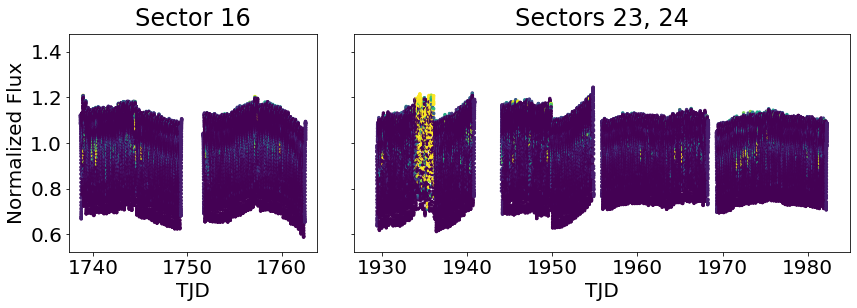

In [137]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('flare_lc_%s.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

(1934, 1939)

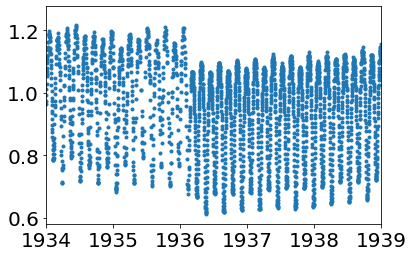

In [147]:
plt.plot(time[1],flux[1],'.')
plt.xlim(1934,1939)

In [139]:
f = open('%s_output.txt' % (name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%f\n' % (name,period,flare_rate.value))
f.close()

In [140]:
savedir = 'results/'

saved_files = glob.glob(savedir+'*')


In [119]:
# saved_files

Failed on: 
44i Boo, BD+42 2437, 2MASS J13272299+4136071, GJ 3729, 2MASS J10534129+5253040, 2MASS J10241364+3902333, PSR J1012+5307, FI Cnc, EZ Peg, PSR J1012+5307, AD Leo, TYC 2834-1385-1, FG Gam, II Peg, DO Cep